# CIMR Level-2 Terrestrial Snow Area

## SCEPS Polar Scene

In [1]:
import os 
import sys
import numpy as np
import xarray as xr
import pyresample as pr
import importlib
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from cartopy import crs as ccrs
import cmcrameri.cm as cmc

# local imports
if '/tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/tools/')
import l2_format as l2
import TSA_algorithm as algorithm
import l2_tools as tools

In [2]:
# reload local imports
importlib.reload(l2)
importlib.reload(algorithm)
importlib.reload(tools)

<module 'l2_tools' from 'C:\\Users\\zschende\\OneDrive - Ilmatieteen laitos\\Files\\Projects\\CIMR Devalgo\\ATBD\\TerrestrialSnowArea_ATBD_v2\\algorithm/tools\\l2_tools.py'>

In [3]:
algo = 'Pulliainen2010'
algo_version = '0.9.0'

l1x_scenes = ('devalgo_geometric', 'devalgo_radiometric', 'sceps_polar1')
l2_grids = ('ease2-3.125km-nh','ease2-1.0km-testcard')

In [4]:
test_card_name = l1x_scenes[2]
l2_grid = l2_grids[1]               # SCEPS scene grid

In [5]:
if test_card_name == 'sceps_polar1':    
    # SCEPS test card
    l1x_path = os.path.abspath('../../../..../') + 'Data/SCEPS/'
    l1x_fn = 'SCEPS_l1x@KA_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc'

## Step 1: Dry Snow Detection

In [6]:
# read L1X data
data_fwd,geo_fwd,data_bck,geo_bck = tools.read_l1x(l1x_path + l1x_fn)

In [7]:
# detection forward and backward
TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

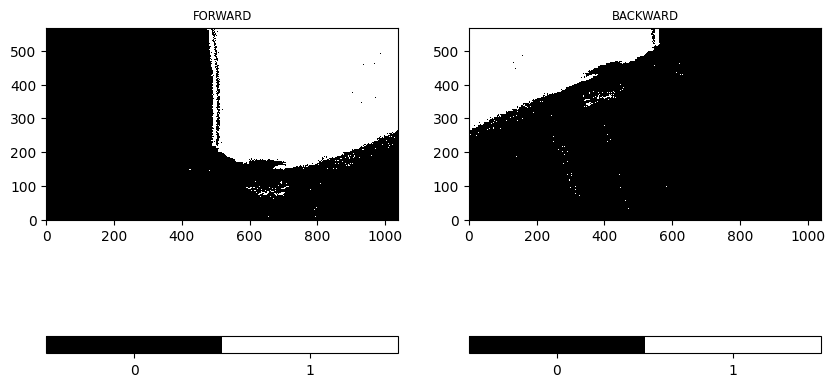

In [8]:
cmap = colors.ListedColormap(['black', 'white'])
vrange=[0,.5,1]
# cmap.set_bad(color='red')

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,10))

img = ax[0].imshow(TSA_fwd, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[0].set_title('FORWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])

img = ax[1].imshow(TSA_bck, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[1].set_title('BACKWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])
    
# fig.savefig('tsa_swath.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

## Step 2: Combined Reprojection

In [9]:
area_def = pr.load_area('ease2_adef.yaml',l2_grid)

cart_crs = area_def.to_cartopy_crs()
# extent = cart_crs.bounds
trg_lon, trg_lat = area_def.get_lonlats()

### Step 2.1: Individual Reprojection

In [10]:
TSA_fwd_proj = tools.reproject_to_grid(TSA_fwd,geo_fwd,area_def=area_def)
TSA_bck_proj = tools.reproject_to_grid(TSA_bck,geo_bck,area_def=area_def)

### Step 2.2: Combining Reprojections

In [11]:
# intermediate combined data
TSA_comb, TSA_comb_uncert = tools.combine_proj(TSA_fwd_proj,TSA_bck_proj)

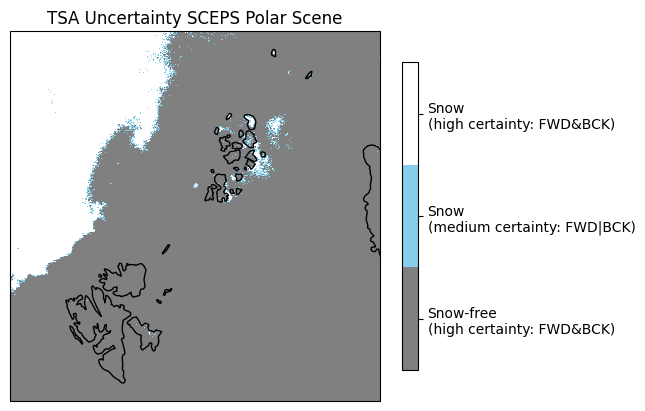

In [12]:
cmap = colors.ListedColormap(['grey', 'skyblue', 'white'])
vrange=[-0.25,0.25,0.75,1.25]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_comb_uncert, transform=ccrs.PlateCarree(), cmap=cmap)
ax.set_title('TSA Uncertainty SCEPS Polar Scene')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,0.5,1], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Snow-free\n(high certainty: FWD&BCK)', 'Snow\n(medium certainty: FWD|BCK)', 'Snow\n(high certainty: FWD&BCK)'])
ax.coastlines()

plt.show()

## Step 3: Masking and Flagging

In [13]:
# load surface information
dem_ref_scenario = os.path.abspath('../../../..../') + 'Data/SCEPS/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc'

data_tc = xr.open_dataset(dem_ref_scenario)
swath_def = pr.geometry.SwathDefinition(lons=data_tc['longitude'].values[0,:,:], lats=data_tc['latitude'].values[0,:,:])
land_mask = pr.kd_tree.resample_nearest(swath_def, np.float64(data_tc['land_sea_ice_mask'].values[0,:,:]), area_def,
                        radius_of_influence=20000/4, fill_value=np.nan)

# data_tc.close()

In [14]:
# prepare land_mask
land_mask[(land_mask == 1) | (land_mask == 9)] = 0      # set water (incl. sea water)
land_mask[land_mask == 2] = 1                           # set land

In [15]:
# status_flag
TSA_status_flag = np.zeros(TSA_comb.shape, dtype='i8')

TSA_status_flag[TSA_status_flag == 0] = 8                    # 8: no data, out of grid
TSA_status_flag[land_mask == 0] = 0                          # 0: water
TSA_status_flag[(TSA_comb == 0) & (land_mask == 1)] = 1      # 1: land
TSA_status_flag[(TSA_comb == 1) & (land_mask == 1)] = 2      # 2: valid snow
# TSA_status_flag[] = 3                                      # 3: [placeholder]

status_flag_comment = '0: water; 1: land; 2: snow (valid); 3-7: [placeholders]; 8: no data, out of grid.'

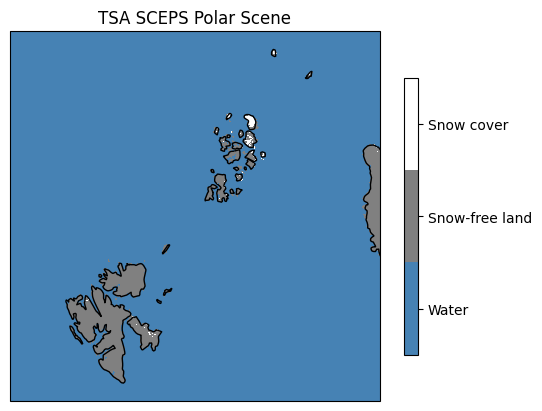

In [16]:
cmap = colors.ListedColormap(['steelblue', 'grey', 'white'])
vrange=[-0.5,0.5,1.5,2.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_status_flag, transform=ccrs.PlateCarree(), cmap=cmap)
ax.set_title('TSA SCEPS Polar Scene')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1,2], orientation='vertical', pad=0.05, shrink=0.75)
cbar.ax.set_yticklabels(['Water', 'Snow-free land', 'Snow cover'])
ax.coastlines()

plt.show()

## Visualization of Scene Snow Conditions

Over land, no specific snow conditions are given. 

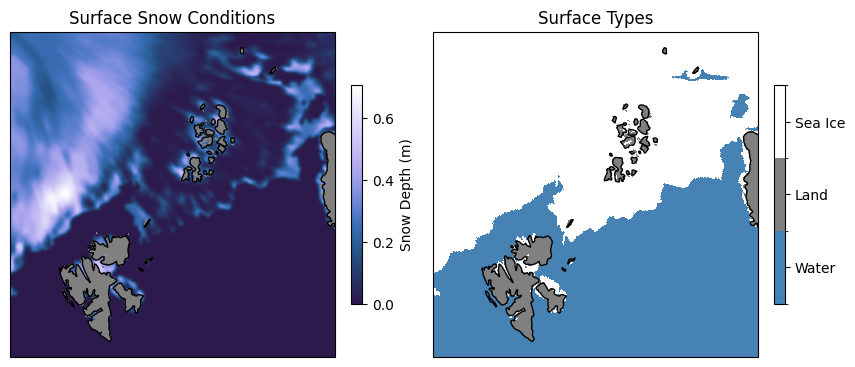

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

cmap = cmc.devon
cmap.set_bad(color='grey')

img = ax[0].pcolormesh(data_tc['longitude'].values[0,:,:], data_tc['latitude'].values[0,:,:], data_tc['snow_thickness'].values[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap)
ax[0].coastlines(color='black')
ax[0].set_title('Surface Snow Conditions')
cbar = plt.colorbar(img, cmap=cmap, fraction=0.031, pad=0.046)
cbar.set_label('Snow Depth (m)')

cmap = colors.ListedColormap(['steelblue', 'grey', 'white'])
vrange=[0.5,1.5,2.5,9.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

img = ax[1].pcolormesh(data_tc['longitude'].values[0,:,:], data_tc['latitude'].values[0,:,:], data_tc['land_sea_ice_mask'].values[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[1].coastlines(color='black')
ax[1].set_title('Surface Types')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[1,2,6], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Water', 'Land', 'Sea Ice'])
    
plt.show()

Demonstration of main criterium for dry snow presence, i.e. brightness temperature difference of KU-KA (h-pol)

In [18]:
# TB reprojection
TB_KUh_fwdproj = tools.reproject_to_grid(data_fwd['KU'].brightness_temperature_h.values,geo_fwd,area_def=area_def)
TB_KAh_fwdproj = tools.reproject_to_grid(data_fwd['KA'].brightness_temperature_h.values,geo_fwd,area_def=area_def)
TB_KAv_fwdproj = tools.reproject_to_grid(data_fwd['KA'].brightness_temperature_v.values,geo_fwd,area_def=area_def)

TB_KUh_bckproj = tools.reproject_to_grid(data_bck['KU'].brightness_temperature_h.values,geo_bck,area_def=area_def)
TB_KAh_bckproj = tools.reproject_to_grid(data_bck['KA'].brightness_temperature_h.values,geo_bck,area_def=area_def)
TB_KAv_bckproj = tools.reproject_to_grid(data_bck['KA'].brightness_temperature_v.values,geo_bck,area_def=area_def)

In [19]:
# TB difference
diff_h_fwdproj = TB_KUh_fwdproj-TB_KAh_fwdproj
diff_h_fwdproj[diff_h_fwdproj < 0] = 0

diff_h_bckproj = TB_KUh_bckproj-TB_KAh_bckproj
diff_h_bckproj[diff_h_bckproj < 0] = 0

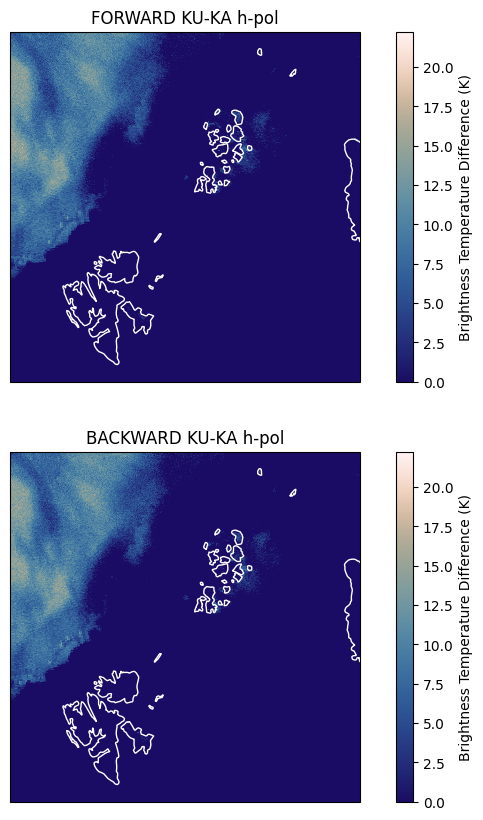

In [20]:
cmap = cmc.lapaz
norm = mpl.colors.Normalize(vmin = np.nanmin(0), vmax = np.nanmax([diff_h_fwdproj, diff_h_bckproj])) 

cart_crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

img = ax[0].pcolormesh(trg_lon, trg_lat, diff_h_fwdproj, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[0].coastlines(color='white')
ax[0].set_title('FORWARD KU-KA h-pol')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, fraction=0.031, pad=0.046)
cbar.set_label('Brightness Temperature Difference (K)')

img = ax[1].pcolormesh(trg_lon, trg_lat, diff_h_bckproj, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[1].coastlines(color='white')
ax[1].set_title('BACKWARD KU-KA h-pol')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, fraction=0.031, pad=0.046)
cbar.set_label('Brightness Temperature Difference (K)')
    
plt.show()